## Evaluation breakdown by sequencing region (CDR v FW)

In [1]:
import pandas as pd
import os
import epam.evaluation as ev
from epam.utils import pcp_path_of_aaprob_path, load_and_filter_pcp_df
from netam.sequences import translate_sequence
from scripts.annotate_pcps import aa_regions_of_row, aa_seq_by_region, get_cdr_fwk_seqs
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [2]:
# Okabe-Ito colors
oi_black         = '#000000'
oi_orange        = '#E69F00'
oi_skyblue       = '#56B4E9'
oi_bluishgreen   = '#009E73'
oi_yellow        = '#F0E442'
oi_blue          = '#0072B2'
oi_vermillion    = '#D55E00'
oi_reddishpurple = '#CC79A7'
os.chdir('/home/mjohnso4/epam/')
test_aaprob_path = 'output/ford-flairr-seq-prod_pcp_2024-04-01_MASKED_NI_noN_no-naive/set2/SHMple_default/combined_aaprob.hdf5'

In [3]:
test_pcp_path = pcp_path_of_aaprob_path(test_aaprob_path)
full_test_pcp_df = load_and_filter_pcp_df(test_pcp_path) # TEMP
test_pcp_df = full_test_pcp_df.head(10).copy() # TEMP
test_pcp_df['parent_aa'] = test_pcp_df.apply(lambda row: translate_sequence(row['parent']), axis=1)
test_pcp_df['child_aa'] = test_pcp_df.apply(lambda row: translate_sequence(row['child']), axis=1)

In [4]:
for index, row in test_pcp_df.iterrows():
    print(row['parent_aa'])
    # print(row['cdr1_codon_start']/3, row['cdr1_codon_end']/3, row['cdr2_codon_start']/3, row['cdr2_codon_end']/3, row['cdr3_codon_start']/3, row['cdr3_codon_end']/3)
    regions = aa_regions_of_row(row)
    print(regions)
    seq_by_region = aa_seq_by_region(row['parent_aa'], regions)
    print(seq_by_region)
    parent_fwk_seq, parent_cdr_seq, child_fwk_seq, child_cdr_seq = get_cdr_fwk_seqs(row)
    # print(parent_fwk_seq) 
    # print(parent_cdr_seq)
    # print(child_fwk_seq)
    # print(child_cdr_seq)

EVQLVQSGAEVKKPGESLKISCKGSGYSFTSYWIGWVRQMPGKGLEWMGIIYPGDSDTRYSPSFQGQVTISADKSISTAYLQWSSLKASDTAMYYCASSGCSGGSCYSGGGPFYWGQGTLVTVSS
{'FWK1': (0, 25), 'CDR1': (25, 33), 'FWK2': (33, 50), 'CDR2': (50, 58), 'FWK3': (58, 96), 'CDR3': (96, 114), 'FWK4': (114, 125)}
{'FWK1': 'EVQLVQSGAEVKKPGESLKISCKGS', 'CDR1': 'GYSFTSYW', 'FWK2': 'IGWVRQMPGKGLEWMGI', 'CDR2': 'IYPGDSDT', 'FWK3': 'RYSPSFQGQVTISADKSISTAYLQWSSLKASDTAMYYC', 'CDR3': 'ASSGCSGGSCYSGGGPFY', 'FWK4': 'WGQGTLVTVSS'}
QVQLVQSGAEVKKPGASVKVSCKASGYTFTNFGISWVRQAPGQGLEWMGWISAYNGNTNYAQRLQGRVTMTTDTSTSTAYMELRSLRSDDTAVYYCARLWSTGYQGDDAFDIWGQGTMVTVSS
{'FWK1': (0, 25), 'CDR1': (25, 33), 'FWK2': (33, 50), 'CDR2': (50, 58), 'FWK3': (58, 96), 'CDR3': (96, 112), 'FWK4': (112, 123)}
{'FWK1': 'QVQLVQSGAEVKKPGASVKVSCKAS', 'CDR1': 'GYTFTNFG', 'FWK2': 'ISWVRQAPGQGLEWMGW', 'CDR2': 'ISAYNGNT', 'FWK3': 'NYAQRLQGRVTMTTDTSTSTAYMELRSLRSDDTAVYYC', 'CDR3': 'ARLWSTGYQGDDAFDI', 'FWK4': 'WGQGTMVTVSS'}
EVQLLESGGGLVQPGGSLRLSCAASGFTFSSYAMSWVRQAPGKGLEWVSAISGSGGSTYYADSVKGRFTISRDN

In [5]:
# problem sequence
print(test_pcp_df.iloc[4])
parent_aa = translate_sequence(test_pcp_df['parent'].iloc[4])
child_aa = translate_sequence(test_pcp_df['child'].iloc[4])
print(ev.locate_child_substitutions(parent_aa, child_aa))
print(test_pcp_df[test_pcp_df['family'] == 2658].shape[0])

sample_id                                             sample-igg-1008
family                                                           2658
parent_name                                                     Node3
parent              CAGGTGCAGCTGGTGCAGTCTGGGGCTGAGGTGAAGAAGCCTGGGG...
child_name                                    1TGGAGTGCGGTTAGTTCTTGGG
child               AAGTTCTTCACCATGGACTGGACCTGGAGGGTCTTCTGCTTGCTGG...
branch_length                                                0.101308
depth                                                               4
distance                                                     0.101311
v_gene                                                    IGHV1-46*01
cdr1_codon_start                                                   75
cdr1_codon_end                                                     96
cdr2_codon_start                                                  150
cdr2_codon_end                                                    171
cdr3_codon_start    

In [6]:
test_pcp_df['parent_fwk_seq'], test_pcp_df['parent_cdr_seq'], test_pcp_df['child_fwk_seq'], test_pcp_df['child_cdr_seq'] = zip(*test_pcp_df.apply(get_cdr_fwk_seqs, axis=1))
print(test_pcp_df.columns)

Index(['sample_id', 'family', 'parent_name', 'parent', 'child_name', 'child',
       'branch_length', 'depth', 'distance', 'v_gene', 'cdr1_codon_start',
       'cdr1_codon_end', 'cdr2_codon_start', 'cdr2_codon_end',
       'cdr3_codon_start', 'cdr3_codon_end', 'parent_is_naive',
       'child_is_leaf', 'parent_aa', 'child_aa', 'parent_fwk_seq',
       'parent_cdr_seq', 'child_fwk_seq', 'child_cdr_seq'],
      dtype='object')


In [7]:
ev.evaluate_dataset(test_aaprob_path)

{'data_set': 'pcp_inputs/ford-flairr-seq-prod_pcp_2024-04-01_MASKED_NI_noN_no-naive.csv',
 'pcp_count': 3111,
 'model': 'SHMple_default',
 'sub_accuracy': 0.2986861313868613,
 'r_precision': 0.13222031962297245,
 'cross_entropy': 0.14771044408299822,
 'fwk_sub_accuracy': 0.333164351617155,
 'fwk_r_precision': 0.13147488708342037,
 'fwk_cross_entropy': 0.09313059112880417,
 'cdr_sub_accuracy': 0.2518589920132195,
 'cdr_r_precision': 0.2067651338260777,
 'cdr_cross_entropy': 0.05457985264522234,
 'avg_k_subs': 5.504660880745741,
 'avg_aa_sub_freq': 0.045334783964647477,
 'aa_sub_freq_range': (0.0, 0.36134453781512604),
 'avg_k_fwk_subs': 3.1703632272581164,
 'avg_fwk_aa_sub_freq': 0.034839156343495783,
 'aa_fwk_sub_freq_range': (0.0, 0.3956043956043956),
 'avg_k_cdr_subs': 2.3342976534876247,
 'avg_cdr_aa_sub_freq': 0.07783271050308006,
 'aa_cdr_sub_freq_range': (0.0, 0.6538461538461539)}

In [ ]:
def evaluate_all_models(aaprob_paths, model_performance_path):
    """
    Wrapper function for evaluate_dataset() that takes in a list of aaprob matrices and outputs a CSV of model performance metrics.
    Outputs to CSV file with columns for the different metrics and a row per model/data set combo.

    Parameters:
    aaprob_paths (list): List of paths to evaluate. Each aaprob matrix corresponds to predictions for one model on a given data set.
    model_performance_path (str): Path to output for model performance metrics.

    """
    model_performances = [ev.evaluate_dataset_by_region(aaprob_path) for aaprob_path in aaprob_paths]

    all_model_performances = pd.DataFrame(model_performances)

    all_model_performances.to_csv(model_performance_path, index=False)

In [4]:
flairr = 'output/ford-flairr-seq-prod_pcp_2024-04-01_MASKED_NI_noN_no-naive/'
race = 'output/rodriguez-airr-seq-race-prod_pcp_2024-04-01_MASKED_NI_noN_no-naive/'
wyatt = 'output/wyatt-10x-1p5m_pcp_2024-04-01_NI_noN_no-naive/'
tang = 'output/tang-deepshm-prod_pcp_2024-04-01_MASKED_NI_noN_no-naive_rearranged/'
ablang1 = 'set1/AbLang1/'
ablang2_mask = 'set1/AbLang2_mask/'
ablang2_wt = 'set1/AbLang2_wt/'
esm = 'set1/ESM1v_mask/'
shmple = 'set2/SHMple_default/'
shmple_prod = 'set2/SHMple_productive/'
shmple_esm = 'set3/SHMpleESM_mask/'
flairr_models = [f"{flairr}{ablang1}combined_aaprob.hdf5", f"{flairr}{ablang2_mask}combined_aaprob.hdf5", f"{flairr}{ablang2_wt}combined_aaprob.hdf5", f"{flairr}{esm}combined_aaprob.hdf5", f"{flairr}{shmple}combined_aaprob.hdf5", f"{flairr}{shmple_prod}combined_aaprob.hdf5", f"{flairr}{shmple_esm}combined_aaprob.hdf5"]
race_models = [f"{race}{ablang1}combined_aaprob.hdf5", f"{race}{ablang2_mask}combined_aaprob.hdf5",  f"{race}{ablang2_wt}combined_aaprob.hdf5", f"{race}{esm}combined_aaprob.hdf5", f"{race}{shmple}combined_aaprob.hdf5", f"{race}{shmple_prod}combined_aaprob.hdf5", f"{race}{shmple_esm}combined_aaprob.hdf5"]
wyatt_models = [f"{wyatt}{ablang1}combined_aaprob.hdf5", f"{wyatt}{ablang2_mask}combined_aaprob.hdf5", f"{wyatt}{ablang2_wt}combined_aaprob.hdf5", f"{wyatt}{esm}combined_aaprob.hdf5", f"{wyatt}{shmple}combined_aaprob.hdf5", f"{wyatt}{shmple_prod}combined_aaprob.hdf5", f"{wyatt}{shmple_esm}combined_aaprob.hdf5"]
tang_models = [f"{tang}{ablang1}combined_aaprob.hdf5", f"{tang}{ablang2_mask}combined_aaprob.hdf5", f"{tang}{ablang2_wt}combined_aaprob.hdf5", f"{tang}{esm}combined_aaprob.hdf5", f"{tang}{shmple}combined_aaprob.hdf5", f"{tang}{shmple_prod}combined_aaprob.hdf5", f"{tang}{shmple_esm}combined_aaprob.hdf5"]
flairr_out = f"{flairr}combined_performance_by_region.csv"
race_out = f"{race}combined_performance_by_region.csv"
wyatt_out = f"{wyatt}combined_performance_by_region.csv"
tang_out = f"{tang}combined_performance_by_region.csv"

In [9]:
print(flairr_models)

['output/ford-flairr-seq-prod_pcp_2024-04-01_MASKED_NI_noN_no-naive/set1/AbLang1/combined_aaprob.hdf5', 'output/ford-flairr-seq-prod_pcp_2024-04-01_MASKED_NI_noN_no-naive/set1/AbLang2_mask/combined_aaprob.hdf5', 'output/ford-flairr-seq-prod_pcp_2024-04-01_MASKED_NI_noN_no-naive/set1/AbLang2_wt/combined_aaprob.hdf5', 'output/ford-flairr-seq-prod_pcp_2024-04-01_MASKED_NI_noN_no-naive/set1/ESM1v_mask/combined_aaprob.hdf5', 'output/ford-flairr-seq-prod_pcp_2024-04-01_MASKED_NI_noN_no-naive/set2/SHMple_default/combined_aaprob.hdf5', 'output/ford-flairr-seq-prod_pcp_2024-04-01_MASKED_NI_noN_no-naive/set2/SHMple_productive/combined_aaprob.hdf5', 'output/ford-flairr-seq-prod_pcp_2024-04-01_MASKED_NI_noN_no-naive/set3/SHMpleESM_mask/combined_aaprob.hdf5']


In [ ]:
evaluate_all_models(flairr_models, flairr_out)

In [ ]:
evaluate_all_models(race_models, race_out)

In [ ]:
evaluate_all_models(wyatt_models, wyatt_out)

In [ ]:
evaluate_all_models(tang_models, tang_out)

In [26]:
def plot_performance_by_region(model_performance_path, data_set, plot_name):
    """
    Plots the performance metrics of models by region.

    Parameters:
    model_performance_path (str): Path to CSV file with model performance metrics.
    plot_path (str): Path to save plot.

    """
    model_performances = pd.read_csv(model_performance_path)
    pcp_count = model_performances['pcp_count'][0]

    fig = plt.figure(figsize=(10,6))
    fig.patch.set_facecolor('white')
    gs = fig.add_gridspec(1, 3)
    axs = gs.subplots(sharex=False, sharey=True)

    bar_width = 0.25
    index = range(len(model_performances))

    # Plotting substitution accuracy
    axs[0].barh([i - bar_width for i in index], model_performances['sub_accuracy'], height=bar_width, color=oi_black, label='Full')
    axs[0].barh(index, model_performances['fwk_sub_accuracy'], height=bar_width, color=oi_reddishpurple, label='FWK')
    axs[0].barh([i + bar_width for i in index], model_performances['cdr_sub_accuracy'], height=bar_width, color=oi_bluishgreen, label='CDR')
    axs[0].set_title("Substitution accuracy")
    axs[0].set_yticks(index)
    axs[0].set_yticklabels(model_performances['model'])

    # Plotting cross-entropy loss
    axs[1].barh([i - bar_width for i in index], model_performances['cross_entropy'], height=bar_width, color=oi_black, label='Full')
    axs[1].barh(index, model_performances['fwk_cross_entropy'], height=bar_width, color=oi_reddishpurple, label='FWK')
    axs[1].barh([i + bar_width for i in index], model_performances['cdr_cross_entropy'], height=bar_width, color=oi_bluishgreen, label='CDR')
    axs[1].set_title("Cross-entropy loss")
    axs[1].set_yticks(index)
    axs[1].set_yticklabels(model_performances['model'])

    # Plotting r-precision
    axs[2].barh([i - bar_width for i in index], model_performances['r_precision'], height=bar_width, color=oi_black, label='Full')
    axs[2].barh(index, model_performances['fwk_r_precision'], height=bar_width, color=oi_reddishpurple, label='FWK')
    axs[2].barh([i + bar_width for i in index], model_performances['cdr_r_precision'], height=bar_width, color=oi_bluishgreen, label='CDR')
    axs[2].set_title("R-precision")
    axs[2].set_yticks(index)
    axs[2].set_yticklabels(model_performances['model'])

    # Adding a single legend for the entire figure
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=3, bbox_to_anchor=(0.85, 1.0))

    fig.suptitle(f'{data_set} ({pcp_count} PCPs)', fontsize=20)
    plt.tight_layout()
    plt.savefig(f"output/plots/{plot_name}.png")
    plt.show()
    plt.close()

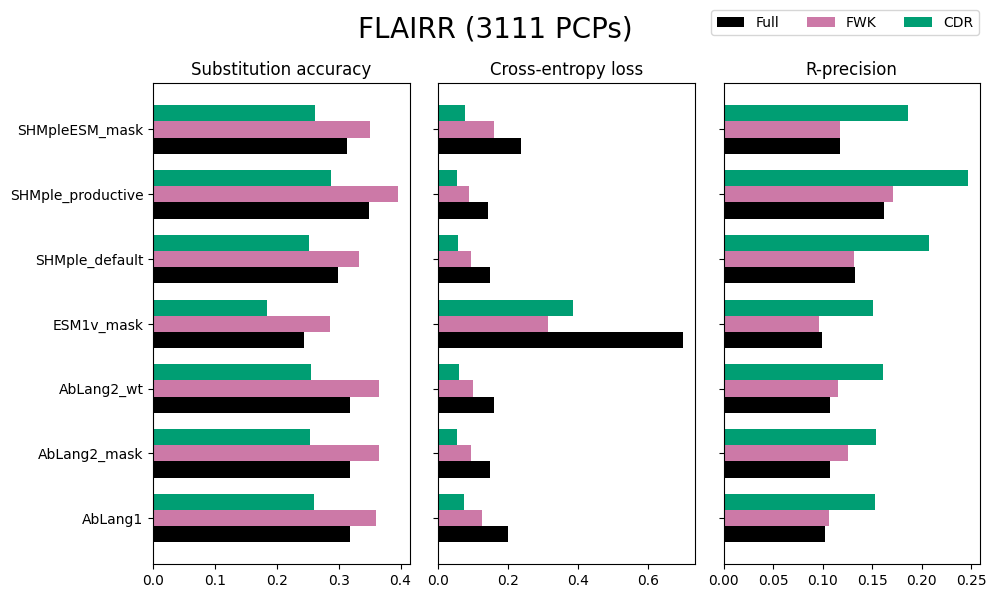

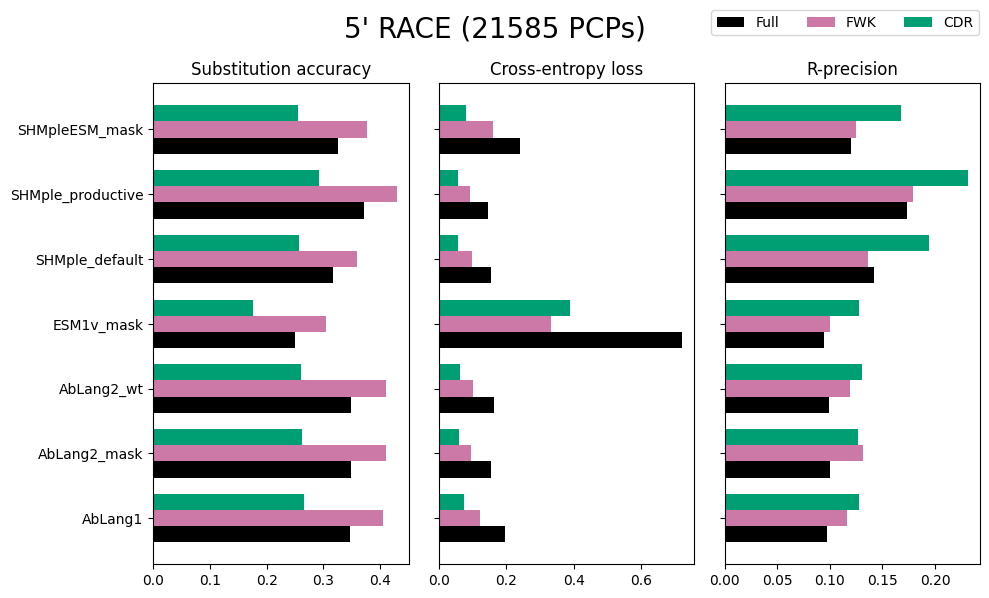

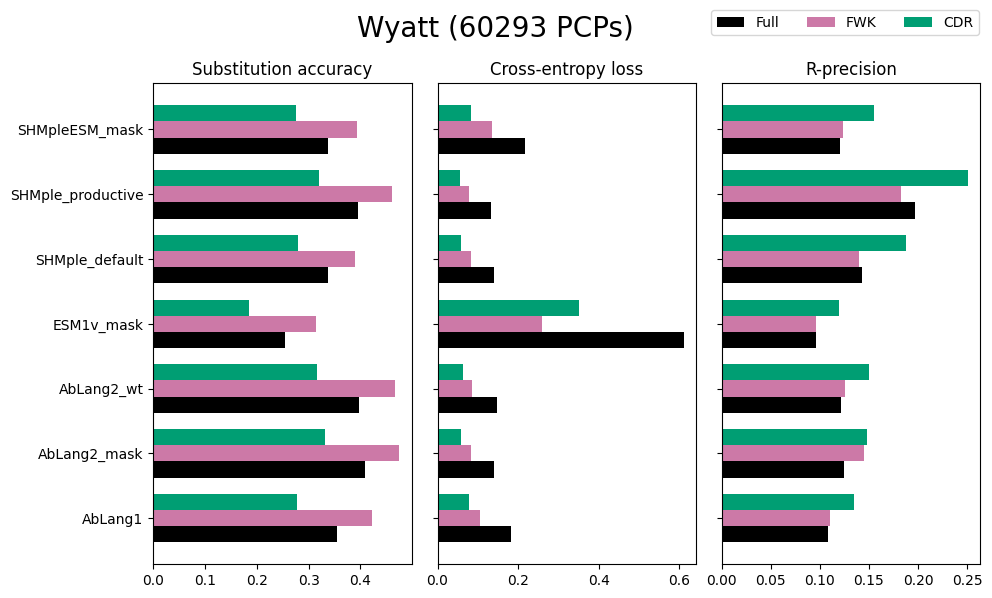

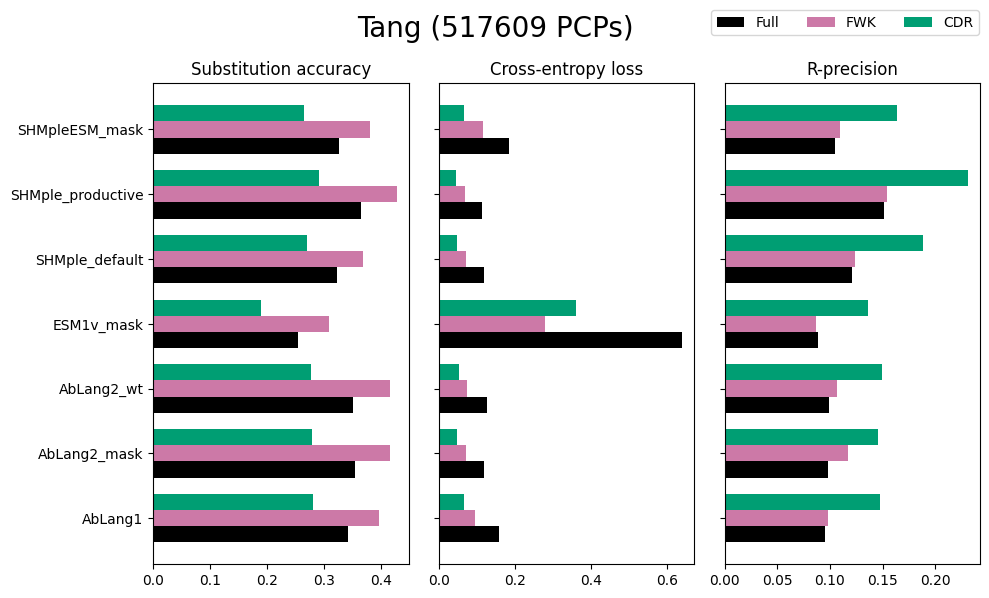

In [28]:
plot_performance_by_region(flairr_out, 'FLAIRR', 'flairr_performance_by_region')
plot_performance_by_region(race_out, "5' RACE", 'race_performance_by_region')
plot_performance_by_region(wyatt_out, 'Wyatt', 'wyatt_performance_by_region')
plot_performance_by_region(tang_out, 'Tang', 'tang_performance_by_region')

In [5]:
ev.evaluate_dataset(flairr_models[4])

{'data_set': 'pcp_inputs/ford-flairr-seq-prod_pcp_2024-04-01_MASKED_NI_noN_no-naive.csv',
 'pcp_count': 2722,
 'model': 'SHMple_default',
 'sub_accuracy': 0.2986861313868613,
 'r_precision': 0.13222031962297245,
 'cross_entropy': 0.16807539595875406,
 'fwk_sub_accuracy': 0.333164351617155,
 'fwk_r_precision': 0.13147488708342037,
 'fwk_cross_entropy': 0.10601230795803399,
 'cdr_sub_accuracy': 0.2518589920132195,
 'cdr_r_precision': 0.2067651338260777,
 'cdr_cross_entropy': 0.062063087647421494,
 'avg_k_subs': 6.291329904481999,
 'avg_aa_sub_freq': 0.05181356095298248,
 'aa_sub_freq_range': (0.007352941176470588, 0.36134453781512604),
 'avg_k_fwk_subs': 3.623438648052902,
 'avg_fwk_aa_sub_freq': 0.03981800712146046,
 'aa_fwk_sub_freq_range': (0.0, 0.3956043956043956),
 'avg_k_cdr_subs': 2.667891256429096,
 'avg_cdr_aa_sub_freq': 0.08895575399525425,
 'aa_cdr_sub_freq_range': (0.0, 0.6538461538461539)}

In [6]:
ev.evaluate_dataset(race_models[4])

{'data_set': 'pcp_inputs/rodriguez-airr-seq-race-prod_pcp_2024-04-01_MASKED_NI_noN_no-naive.csv',
 'pcp_count': 19550,
 'model': 'SHMple_default',
 'sub_accuracy': 0.316655338732527,
 'r_precision': 0.1415837610484977,
 'cross_entropy': 0.1695754301253733,
 'fwk_sub_accuracy': 0.35921920486028097,
 'fwk_r_precision': 0.13672322950671734,
 'fwk_cross_entropy': 0.10686009655234292,
 'cdr_sub_accuracy': 0.25732209370711623,
 'cdr_r_precision': 0.19441813392076665,
 'cdr_cross_entropy': 0.06271533324005851,
 'avg_k_subs': 6.246393861892583,
 'avg_aa_sub_freq': 0.05149306086254904,
 'aa_sub_freq_range': (0.006993006993006993, 0.38461538461538464),
 'avg_k_fwk_subs': 3.6371867007672636,
 'avg_fwk_aa_sub_freq': 0.03996908462381608,
 'aa_fwk_sub_freq_range': (0.0, 0.4175824175824176),
 'avg_k_cdr_subs': 2.60920716112532,
 'avg_cdr_aa_sub_freq': 0.08729009401013635,
 'aa_cdr_sub_freq_range': (0.0, 0.7058823529411765)}

In [7]:
ev.evaluate_dataset(wyatt_models[4])

{'data_set': 'pcp_inputs/wyatt-10x-1p5m_pcp_2024-04-01_NI_noN_no-naive.csv',
 'pcp_count': 55736,
 'model': 'SHMple_default',
 'sub_accuracy': 0.3381895783972711,
 'r_precision': 0.14314313082014918,
 'cross_entropy': 0.15209390933875738,
 'fwk_sub_accuracy': 0.3902560325344514,
 'fwk_r_precision': 0.13986567793320412,
 'fwk_cross_entropy': 0.08890873423865431,
 'cdr_sub_accuracy': 0.2785636012342475,
 'cdr_r_precision': 0.18799034641879697,
 'cdr_cross_entropy': 0.06318517477237592,
 'avg_k_subs': 5.338650064590211,
 'avg_aa_sub_freq': 0.04404834231837546,
 'aa_sub_freq_range': (0.0070921985815602835, 0.3076923076923077),
 'avg_k_fwk_subs': 2.849989234964834,
 'avg_fwk_aa_sub_freq': 0.03131856302159158,
 'aa_fwk_sub_freq_range': (0.0, 0.3076923076923077),
 'avg_k_cdr_subs': 2.4886608296253767,
 'avg_cdr_aa_sub_freq': 0.08368604094915655,
 'aa_cdr_sub_freq_range': (0.0, 0.6451612903225806)}

In [8]:
ev.evaluate_dataset(tang_models[4])